In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
df = pd.read_csv('./GOLD_H1_201401020900_202312070800.csv',sep='\t')
df

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
0,2014.01.02,09:00:00,1225.05,1228.42,1220.52,1222.86,3523,0,0
1,2014.01.02,10:00:00,1222.86,1223.91,1219.66,1221.65,2353,0,0
2,2014.01.02,11:00:00,1221.66,1221.96,1219.10,1221.26,2038,0,0
3,2014.01.02,12:00:00,1221.29,1221.83,1219.26,1221.25,1500,0,0
4,2014.01.02,13:00:00,1221.25,1221.46,1216.51,1217.95,2973,0,0
...,...,...,...,...,...,...,...,...,...
58880,2023.12.07,04:00:00,2026.08,2029.87,2026.04,2028.95,3594,0,30
58881,2023.12.07,05:00:00,2028.90,2029.78,2026.36,2026.76,3409,0,26
58882,2023.12.07,06:00:00,2026.70,2026.95,2025.24,2025.92,2731,0,26
58883,2023.12.07,07:00:00,2025.83,2027.23,2025.11,2026.66,3197,0,26


In [3]:
df.columns

Index(['<DATE>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>',
       '<VOL>', '<SPREAD>'],
      dtype='object')

In [4]:
df.describe()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
count,58885.000000,58885.000000,58885.000000,58885.000000,58885.000000,5.888500e+04,58885.000000
mean,1486.987253,1488.787756,1485.156028,1487.002351,4387.026730,5.616019e+13,30.835561
std,291.542513,292.010318,291.025572,291.548730,4309.246894,2.763920e+14,11.246721
min,1049.960000,1050.580000,1046.290000,1049.960000,1.000000,0.000000e+00,0.000000
25%,1245.190000,1246.470000,1244.010000,1245.190000,1674.000000,0.000000e+00,25.000000
50%,1327.810000,1329.130000,1326.510000,1327.800000,3215.000000,0.000000e+00,32.000000
75%,1792.230000,1794.170000,1790.290000,1792.250000,5495.000000,0.000000e+00,38.000000
max,2117.400000,2144.630000,2090.600000,2117.370000,102129.000000,4.009700e+15,397.000000


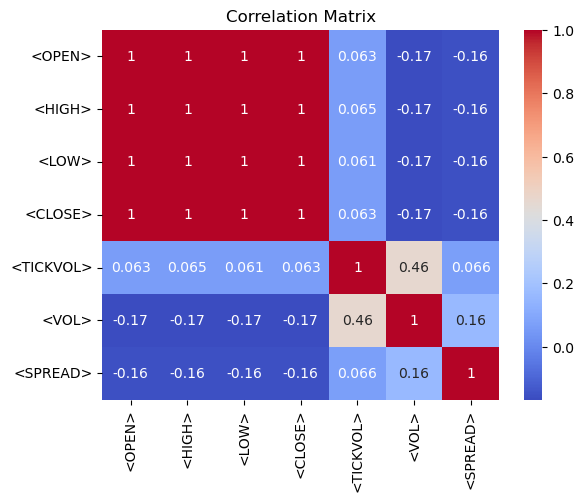

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.drop(["<DATE>", "<TIME>"], axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [6]:
df.isnull().sum()

<DATE>       0
<TIME>       0
<OPEN>       0
<HIGH>       0
<LOW>        0
<CLOSE>      0
<TICKVOL>    0
<VOL>        0
<SPREAD>     0
dtype: int64

In [7]:
for column in df.columns:
    print(column, df[column].nunique())

<DATE> 2565
<TIME> 24
<OPEN> 37646
<HIGH> 37691
<LOW> 37842
<CLOSE> 37667
<TICKVOL> 13119
<VOL> 2765
<SPREAD> 148


In [8]:
df.sample(10)

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
49735,2022.05.24,06:00:00,1850.82,1855.83,1850.71,1855.67,2564,0,25
40255,2020.10.13,18:00:00,1892.31,1895.41,1889.95,1894.57,5246,0,33
42560,2021.03.08,02:00:00,1707.53,1708.01,1704.99,1706.86,3445,0,35
49638,2022.05.18,01:00:00,1814.55,1815.61,1814.01,1814.32,1135,0,25
38748,2020.07.14,02:00:00,1802.46,1802.46,1800.98,1802.31,931,0,36
20401,2017.05.31,18:00:00,1267.07,1268.30,1266.37,1267.45,20452,2045199999979548,40
16657,2016.10.11,04:00:00,1256.53,1258.65,1255.99,1258.65,4614,0,40
26871,2018.07.06,03:00:00,1257.20,1257.72,1256.27,1256.68,3443,0,30
23723,2017.12.20,20:00:00,1266.46,1266.81,1265.22,1265.53,8793,0,40
35118,2019.11.28,03:00:00,1457.49,1458.05,1456.60,1457.12,1538,0,28


## Merge date and time

In [9]:
def convert_datetime(df):
    df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'], format='%Y.%m.%d %H:%M:%S')
    df = df.drop(["<DATE>", "<TIME>"], axis=1)
    return df

df = convert_datetime(df)
df.set_index('<DATETIME>', inplace=True)
df

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
<DATETIME>,,,,,,,
2014-01-02 09:00:00,1225.05,1228.42,1220.52,1222.86,3523,0,0
2014-01-02 10:00:00,1222.86,1223.91,1219.66,1221.65,2353,0,0
2014-01-02 11:00:00,1221.66,1221.96,1219.10,1221.26,2038,0,0
2014-01-02 12:00:00,1221.29,1221.83,1219.26,1221.25,1500,0,0
2014-01-02 13:00:00,1221.25,1221.46,1216.51,1217.95,2973,0,0
...,...,...,...,...,...,...,...
2023-12-07 04:00:00,2026.08,2029.87,2026.04,2028.95,3594,0,30
2023-12-07 05:00:00,2028.90,2029.78,2026.36,2026.76,3409,0,26
2023-12-07 06:00:00,2026.70,2026.95,2025.24,2025.92,2731,0,26


## Bad and unwanted column

In [10]:
df[df["<VOL>"] != 0]

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
<DATETIME>,,,,,,,
2017-02-02 16:00:00,1223.52,1223.60,1219.85,1221.47,18611,1329499999986705,40
2017-02-02 17:00:00,1221.42,1221.87,1216.15,1216.76,23109,2310899999976891,40
2017-02-02 18:00:00,1216.78,1218.71,1215.16,1218.12,21142,2114199999978858,40
2017-02-02 19:00:00,1218.12,1218.41,1213.51,1215.29,15446,1544599999984554,40
2017-02-02 20:00:00,1215.31,1217.96,1214.85,1215.79,4809,480799999995192,40
...,...,...,...,...,...,...,...
2017-08-04 19:00:00,1256.68,1258.21,1256.20,1257.18,14556,1455599999985444,40
2017-08-04 20:00:00,1257.18,1258.96,1256.88,1257.90,11792,1179199999988208,40
2017-08-04 21:00:00,1257.90,1258.98,1257.18,1258.26,9815,981499999990185,40


In [11]:
df = df.drop(["<VOL>", "<SPREAD>", "<TICKVOL>"], axis=1)
df

,<OPEN>,<HIGH>,<LOW>,<CLOSE>
<DATETIME>,,,,
2014-01-02 09:00:00,1225.05,1228.42,1220.52,1222.86
2014-01-02 10:00:00,1222.86,1223.91,1219.66,1221.65
2014-01-02 11:00:00,1221.66,1221.96,1219.10,1221.26
2014-01-02 12:00:00,1221.29,1221.83,1219.26,1221.25
2014-01-02 13:00:00,1221.25,1221.46,1216.51,1217.95
...,...,...,...,...
2023-12-07 04:00:00,2026.08,2029.87,2026.04,2028.95
2023-12-07 05:00:00,2028.90,2029.78,2026.36,2026.76
2023-12-07 06:00:00,2026.70,2026.95,2025.24,2025.92


# Drop  OPEN HIGH LOW because correlation is super high

In [12]:
df = df.drop(["<OPEN>", "<HIGH>", "<LOW>"], axis=1)

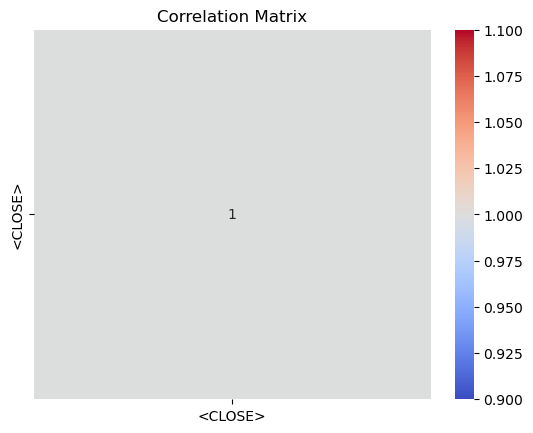

In [13]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# DATA OVERVIEW

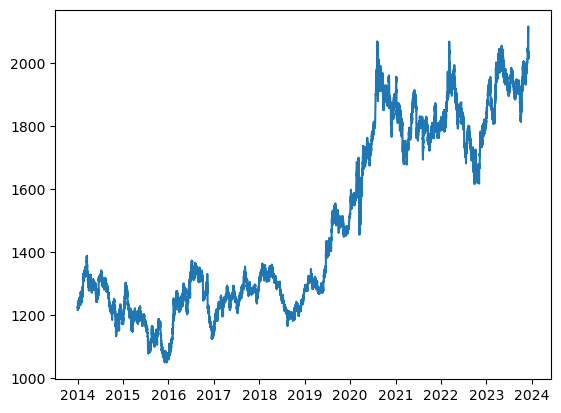

In [14]:
plt.plot(df['<CLOSE>'])

# Prepare data for supervised learning

In [15]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X
X,Y = create_features(df, label='<CLOSE>')

## Split dataset

In [16]:
# split a univariate dataset into train/test sets
x_train_full, x_test, y_train_full, y_test = train_test_split(X, Y, test_size = 0.1, random_state=42,shuffle=False) # test must not be shuffle
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.3, random_state=42, shuffle=True)

## XGB model

In [17]:
xgb_params_grid = param_dist = {
    'max_depth': [4,8,16,32,64],
    'learning_rate': [ 0.01, 0.1 ],
    'subsample': np.linspace(0.5, 1, 4),
    'n_estimators': [25, 50, 100],
}
xgb_grid = GridSearchCV(XGBRegressor(), xgb_params_grid, n_jobs=-1, verbose=1)

In [18]:
xgb_grid.fit(x_train, y_train,
        eval_set=[(x_val, y_val)],
       verbose=False)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/home/ss/.conda/envs/ML_Lab/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [4, 8, 16, 32, 64],
                         'n_estimators': [25, 50, 100],
                         'subsample': array([0.5       , 0.66666667, 0.83333333, 1.        ])},
             verbose=1)

In [19]:
y_pred_xgb = xgb_grid.predict(x_test)

In [20]:
xgb_grid.best_params_

{'learning_rate': 0.1,
 'max_depth': 32,
 'n_estimators': 100,
 'subsample': 0.8333333333333333}

## Random forrest

In [21]:
rf_params_grid = {
    'max_depth': [25,50,100,200],
    'n_estimators': [25, 50, 100],
}

rf_grid = GridSearchCV(RandomForestRegressor(), rf_params_grid,cv=5, n_jobs=-1, verbose=1)

In [22]:
rf_grid.fit(x_train_full, y_train_full)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/ss/.conda/envs/ML_Lab/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [25, 50, 100, 200],
                         'n_estimators': [25, 50, 100]},
             verbose=1)

In [23]:
y_pred_tree = rf_grid.predict(x_test)

In [24]:
rf_grid.best_params_

{'max_depth': 100, 'n_estimators': 50}

# Linear regression

In [25]:
linear_params_grid = {
    'fit_intercept': [True, False],
}
linear_grid = GridSearchCV(LinearRegression(), linear_params_grid, n_jobs=-1, verbose=1)
linear_grid.fit(x_train_full, y_train_full)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False]}, verbose=1)

In [26]:
linear_pred = linear_grid.predict(x_test)

In [27]:
linear_grid.best_params_

{'fit_intercept': True}

# Predicting a totally unseen data

In [28]:
def showResult(y_pred):
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('R2 Score:', r2_score(y_test, y_pred))

    plt.plot(pd.DataFrame({"Predicted":y_pred} ,index=y_test.index) , label='Predicted')
    plt.plot(y_test, label='Real')
    plt.legend()
    plt.show()

Mean Absolute Error: 144.10233968472073
Mean Squared Error: 28616.309286415308
R2 Score: -6.155595493754578


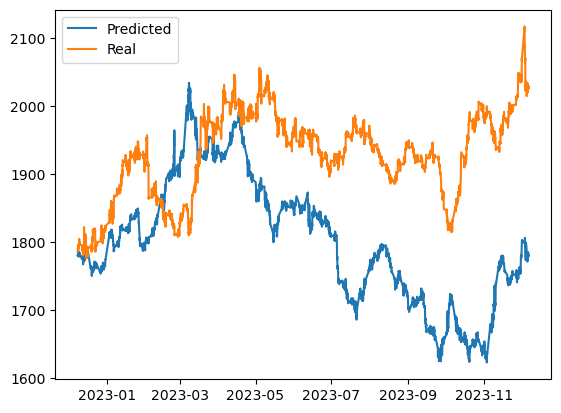

In [29]:
showResult(y_pred_xgb)

Mean Absolute Error: 144.00502516556287
Mean Squared Error: 28606.91848118524
R2 Score: -6.153247294239593


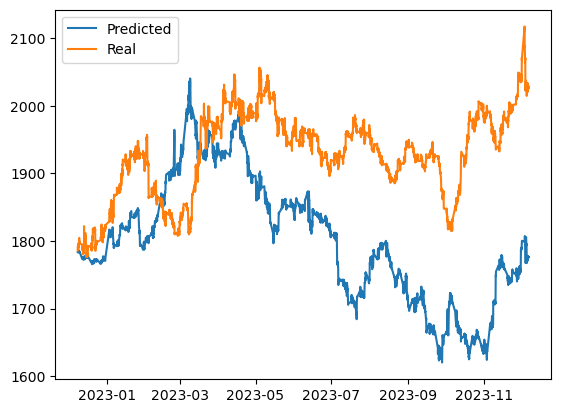

In [30]:
showResult(y_pred_tree)

Mean Absolute Error: 74.93450681714204
Mean Squared Error: 7953.305757943666
R2 Score: -0.9887483837411055


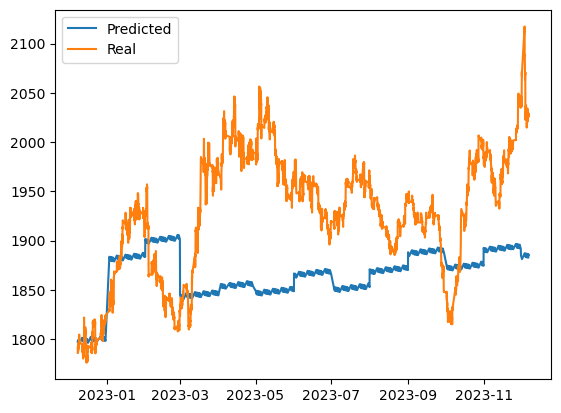

In [31]:
showResult(linear_pred)